# Lecture 2: Introduction to Deep Learning

In this lecture, we will introduce the basics of deep learning.

## Bigram Language Model

### Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
from src.utils import load_text, set_seed, configure_device

### Configuration

In [2]:
@dataclass
class BigramConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/raw/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    tokenizer: str = "char"
    vocab_size: int = 0  # Set later

    seed: int = 101

### Reproducibility

In [3]:
set_seed(BigramConfig.seed)

Random seed set to 101


### Device

In [4]:
BigramConfig.device = configure_device()

Running on mps


### Dataset

In [5]:
# Load text and split by lines
names_text = load_text(BigramConfig.root_dir + BigramConfig.dataset_path).splitlines()

Loaded text data from /Users/pathfinder/Documents/GitHub/LLM101/notebooks/Lectures/../../data/raw/names.txt (length: 228145 characters).


#### Statistics

In [6]:
print(f"Number of names: {len(names_text)}")
print(f"First 5 names: {names_text[:5]}")
print(f"Maximum name length: {max(len(name) for name in names_text)}")
print(f"Minimum name length: {min(len(name) for name in names_text)}")

Number of names: 32033
First 5 names: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Maximum name length: 15
Minimum name length: 2


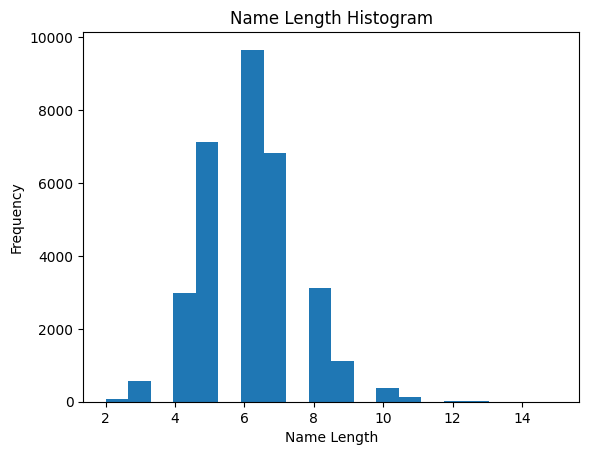

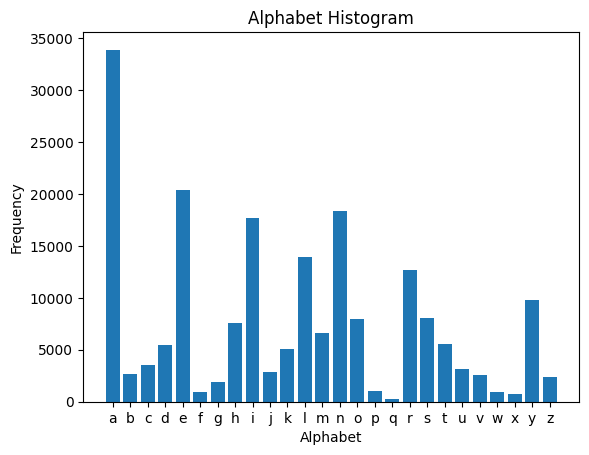

In [7]:
# Plot name length
plt.hist([len(name) for name in names_text], bins=20)
plt.xlabel("Name Length")
plt.ylabel("Frequency")
plt.title("Name Length Histogram")
plt.show()

# Plot alphabet frequency
alphabet = [chr(i) for i in range(97, 123)]  # all alphabet characters
alphabet_counts = torch.zeros(len(alphabet))
for name in names_text:
    for char in name:
        alphabet_counts[ord(char) - 97] += 1

plt.bar(alphabet, alphabet_counts)
plt.xlabel("Alphabet")
plt.ylabel("Frequency")
plt.title("Alphabet Histogram")
plt.show()

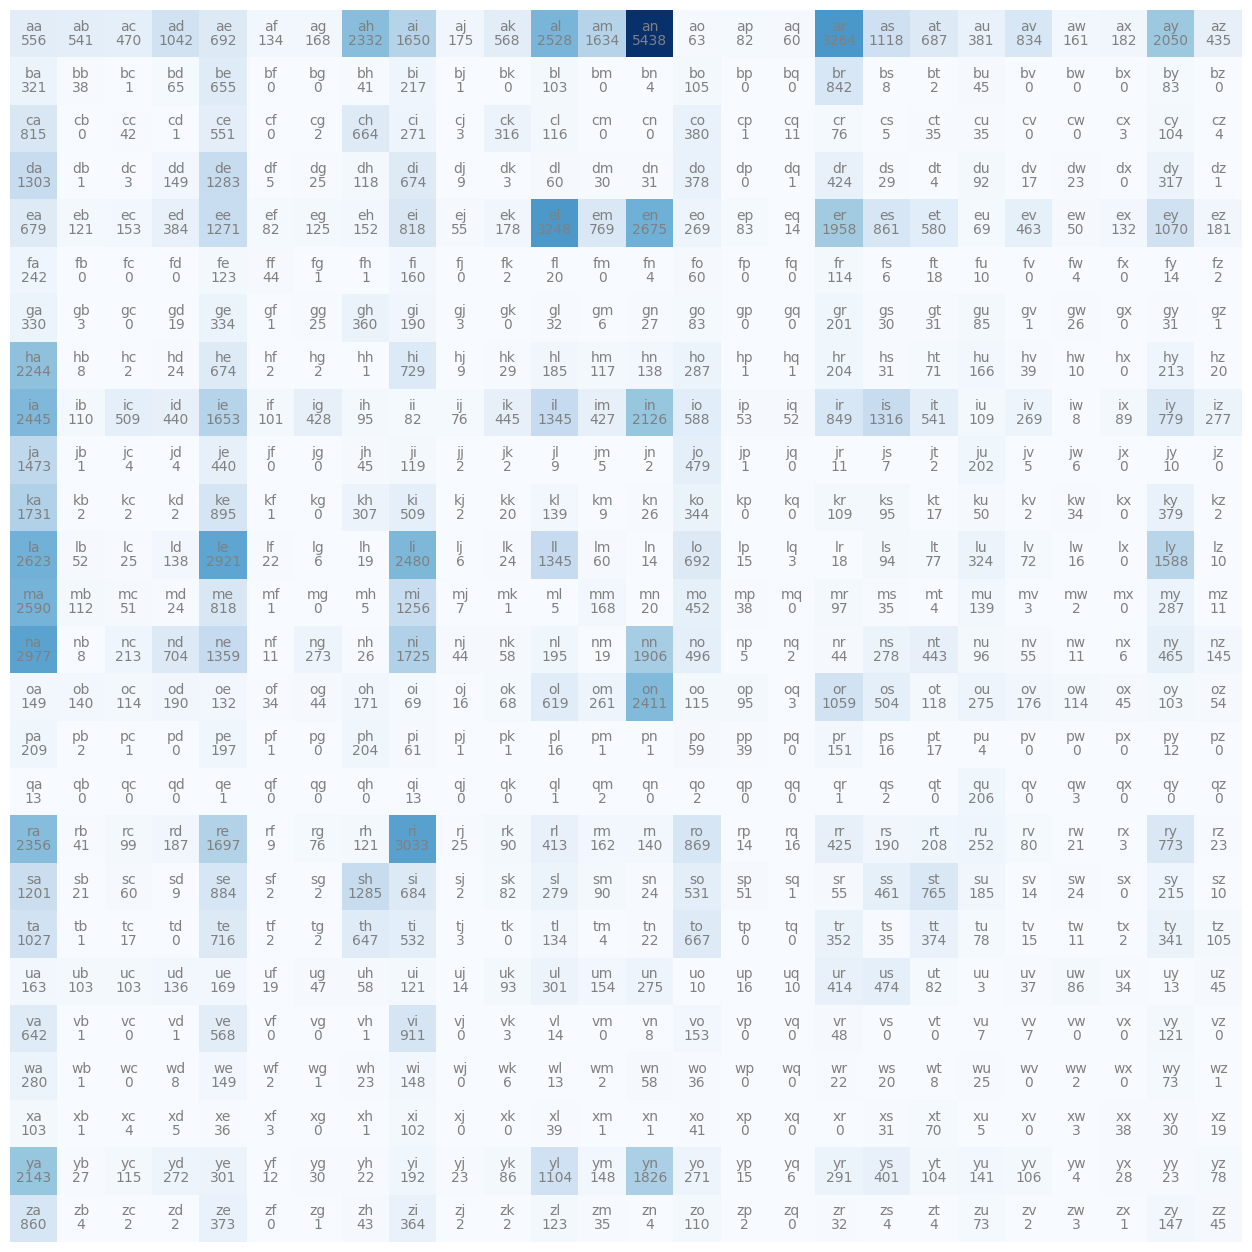

In [8]:
# Plot what alphabet comes after other alphabets
alphabet = [chr(i) for i in range(97, 123)]  # all alphabet characters
alphabet2idx = {char: idx for idx, char in enumerate(alphabet)}
idx2alphabet = {idx: char for char, idx in alphabet2idx.items()}
alphabet_counts = torch.zeros(len(alphabet), len(alphabet), dtype=torch.int32)
for name in names_text:
    for char1, char2 in zip(name, name[1:]):
        alphabet_counts[alphabet2idx[char1], alphabet2idx[char2]] += 1

plt.figure(figsize=(16, 16))
plt.imshow(alphabet_counts, cmap='Blues')
for i in range(len(alphabet)):
    for j in range(len(alphabet)):
        stat = idx2alphabet[i] + idx2alphabet[j]
        plt.text(j, i, stat, ha='center', va='bottom', color='gray')
        plt.text(j, i, alphabet_counts[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')
plt.show()

### Preprocessing

#### 1. Add special tokens

We need special tokens to indicate the beginning and the end of a name.

If we don't add a special token to indicate the end of a name, the model will never stop generating names.
We will add a special token `<E>` to indicate the end of a name.

In [9]:
# Add special token
names_text = ["<S>" + name + "<E>" for name in names_text]
print(f"First 5 names: {names_text[:5]}")

First 5 names: ['<S>emma<E>', '<S>olivia<E>', '<S>ava<E>', '<S>isabella<E>', '<S>sophia<E>']


In [10]:
# Just kidding, we just need the end token

# Reload the data
names_text = load_text(BigramConfig.root_dir + BigramConfig.dataset_path).splitlines()

# Add special token
# We will add a special token '.' to indicate the end of a name.
names_text = [name + "." for name in names_text]
print(f"First 5 names: {names_text[:5]}")

Loaded text data from /Users/pathfinder/Documents/GitHub/LLM101/notebooks/Lectures/../../data/raw/names.txt (length: 228145 characters).
First 5 names: ['emma.', 'olivia.', 'ava.', 'isabella.', 'sophia.']


#### 2. Tokenize

To feed the names to the model, we need to convert them to integers. Tokenization is the process of converting text to integers.

We will use a character-level tokenizer. ('a' -> 0, 'b' -> 1, ..., 'z' -> 25, '.' -> 26)

In [11]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.append(".")  # Add special token
print(f"Characters: {chars}")

# Create mapping
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}
print(f"str2idx: {str2idx}")
print(f"idx2str: {idx2str}")

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.']
str2idx: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '.': 26}
idx2str: {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '.'}


In [12]:
# Make it into a class for reusability
class CharTokenizer:
    def __init__(self, chars):
        self.str2idx = {char: idx for idx, char in enumerate(chars)}
        self.idx2str = {idx: char for char, idx in self.str2idx.items()}

    def vocab_size(self):
        return len(self.str2idx)

    def encode(self, text):
        return torch.tensor([self.str2idx[char] for char in text], dtype=torch.long)

    def decode(self, tokens):
        return ''.join([self.idx2str[token] for token in tokens])

In [13]:
chars = [chr(i) for i in range(97, 123)] # all alphabet characters
tokenizer = CharTokenizer(chars)
BigramConfig.vocab_size = tokenizer.vocab_size()

### First sampling

In [14]:
# Create a tensor to store what alphabet comes after other alphabets
alphabet_counts = torch.zeros(BigramConfig.vocab_size, BigramConfig.vocab_size)
for name in names_text:
    for char1, char2 in zip(name, name[1:]):
        alphabet_counts[tokenizer.encode(char1).item(), tokenizer.encode(char2).item()] += 1
print(alphabet_counts.shape)


KeyError: '.'

### Model



In [6]:
class Bigram(nn.Module):
    def __init__(self, config: BigramConfig):
        super(Bigram, self).__init__()
        self.vocab_size = config.vocab_size
        self.probs = nn.Parameter(torch.randn(config.vocab_size, config.vocab_size))

    def forward(self, x):  # x: (batch_size, 1)
        logits = self.probs[x]  # (batch_size, 1, vocab_size)
        return logits

    def loss(self, logits, target):
        logits = logits.view(-1, self.vocab_size)  # (batch_size, vocab_size)
        target = target.view(-1)  # (batch_size)
        return F.cross_entropy(logits, target)

    @torch.no_grad()
    def generate(self, tokenizer, prompt, max_new_tokens, device, temperature=1.0):
        if temperature < 0.0 or temperature > 1.0:
            raise ValueError("temperature must be between 0.0 and 1.0")

        self.eval()
        print(prompt)

        # Encode
        x = tokenizer.encode(prompt).to(device).unsqueeze(0)  # (batch_size=1, prompt_size)

        # Generation loop
        for _ in range(max_new_tokens):
            # Truncate
            context = x[:, -1:]  # (batch_size=1, 1)

            # Forward
            logits = self.forward(context)[:, -1, :] / temperature  # (batch_size=1, vocab_size)

            # Sample
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # (batch_size=1, 1)

            # Concatenate
            x = torch.cat([x, next_token], dim=-1)  # (batch_size=1, 2)

            # Decode
            text = tokenizer.decode([next_token[0].item()])
            print(text, end='', flush=True)

In [7]:
# Initialize model
model = Bigram(BigramConfig()).to(BigramConfig.device)

In [8]:
# Test forward pass
x = torch.randint(0, BigramConfig.vocab_size, (2, 1), dtype=torch.long).to(BigramConfig.device)
logits = model(x)
print(logits.shape)

torch.Size([2, 1, 256])
